# Introduction to AMPy - a baseline library for Active Matter data processing

In this notebook we will tell you about usage basics of [AMPy](https://github.com/swarmtronics/AMPy). The main topics of this tutorial are multi-object tracking and further extraction of statistical characteristics from obtained kinematics.

In [1]:
# install ampy
!pip install ampy

# install gdown to download the test video
!pip install gdown

  Using cached ampy-0.1.2-py3-none-any.whl (11 kB)
  Using cached ffmpeg_python-0.2.0-py3-none-any.whl (25 kB)
     -------------------------------------- 313.2/313.2 kB 2.4 MB/s eta 0:00:00
  Using cached matplotlib-3.7.2-cp310-cp310-win_amd64.whl (7.5 MB)
  Attempting uninstall: imageio
    Found existing installation: imageio 2.26.0
    Uninstalling imageio-2.26.0:
      Successfully uninstalled imageio-2.26.0
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.0
    Uninstalling matplotlib-3.7.0:
      Successfully uninstalled matplotlib-3.7.0


In [8]:
import gdown

url = 'https://drive.google.com/uc?id=1l6j1bSW2sazQhPSM4bTFpH5m3pqyKrOc'
filename = 'test_video.mp4'
gdown.download(url, filename, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1l6j1bSW2sazQhPSM4bTFpH5m3pqyKrOc
To: C:\Users\Eighonet Aerta\Desktop\AMPy\test_video.mp4
100%|█████████████████████████████████████████████████████████████████████████████| 38.0M/38.0M [00:01<00:00, 36.7MB/s]


'test_video.mp4'

First, let us inspect our data. For the demonstration purposes, we provide a 30-second recording of the Swarmodroid platform with 65 stadium-shaped bots in ~100 cm field.

In [9]:
def get_video(filename, begin_frame, end_frame, get_each):
    video_capture = cv2.VideoCapture(filename)

    if begin_frame < 1: # pragma: no cover
        start_frame = 1
    else:
        start_frame = begin_frame

    frames_number = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

    if end_frame > frames_number: # pragma: no cover
        finish_frame = frames_number
    else:
        finish_frame = end_frame
    
    frames = []
    raw_cart_kin = []
    for current_frame in tqdm(range(start_frame, finish_frame + 1, get_each)):
        video_capture.set(cv2.CAP_PROP_POS_FRAMES, current_frame - 1)
        success, frame = video_capture.read()
        if success: # pragma: no cover
            frames.append(frame)
    return frames

In [10]:
import cv2
from tqdm import tqdm 

video = get_video(filename, 120, 1800, 5)

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [01:15<00:00,  3.69it/s]


In [7]:
video 

[]

In [37]:
!pip install celluloid

  Using cached celluloid-0.2.0-py3-none-any.whl (5.4 kB)


In [12]:
video[1].shape

(1080, 1920, 3)

In [17]:
from ampy.statistics2d import mean_polar_angle_absolute
from ampy.statistics2d import mean_polar_angle
from ampy.statistics2d import mean_distance_from_center

from ampy.statistics2d import chi_4
from ampy.statistics2d import mean_cartesian_displacements
from ampy.statistics2d import bond_orientation
from ampy.statistics2d import cluster_dynamics

from multiprocessing import Pool
import os

def get_stcp(cart_kin):
    time = [i for i in range(len(cart_kin))]
    data = []
    for time in time:
      data.append((cart_kin, time, 100))

    with Pool(os.cpu_count()) as pool:
      stcp = pool.starmap(chi_4, data)
    
    return stcp

center = (1920 // 2, 1080 // 2)

polar_kin = VP.polar_kinematics(cartesian_kinematics=cart_kin,
                                field_center=center)

distance = mean_distance_from_center(kinematics=polar_kin)
angle_abs = mean_polar_angle_absolute(kinematics=polar_kin)
angle = mean_polar_angle(kinematics=polar_kin)

cart_disp = mean_cartesian_displacements(kinematics=cart_kin)
boo = bond_orientation(kinematics=cart_kin, neighbours_number=6, folds_number=6)
cl_coeff = cluster_dynamics(kinematics=cart_kin)
stcp = get_stcp(cart_kin)

100%|██████████████████████████████████████████████████████████████████████████████| 277/277 [00:00<00:00, 4644.11it/s]


In [19]:
[type(item) for item in [cart_disp, boo, stcp, cl_coeff, distance, angle, angle_abs]]

[list, list, list, list, list, list, list]

In [31]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from celluloid import Camera

def get_dashboard(output_name:str,
                  cart_disp:list,
                  boo:list,
                  stcp:list, 
                  cl_coeff:list,
                  distance:list,
                  angle:list,
                  angle_abs:list,
                  fps:int,
                 ) -> None:
    """
    Creates .gif with simulteneous evolution of the system parameters along with еру original video
    
    :param output_name: name of the output file
    :param cart_disp: cartesian displacement
    :param boo: bond orientational order parameter
    :param stcp: spatio-temporal correlation parameter
    :param cl_coeff: clustering coefficient
    :param distance: mean distance from the center
    :param angle: mean polar angle
    :param angle_abs: absolute value of the mean polar angle
    :param fps: frames per second
    """
    
    fig, ax = plt.subplots()
    fig = plt.figure(layout="constrained", figsize = (12,8))
    
    gs = gridspec.GridSpec(4, 4, figure=fig)
    
    ax1 = fig.add_subplot(gs[:3, :3])
    ax2 = fig.add_subplot(gs[:1, -1])
    ax3 = fig.add_subplot(gs[1:2, -1])
    ax4 = fig.add_subplot(gs[2:3, -1])
    ax5 = fig.add_subplot(gs[3:4, -1])
    ax6 = fig.add_subplot(gs[-1, 0])
    ax7 = fig.add_subplot(gs[-1, 1])
    ax8 = fig.add_subplot(gs[-1, 2])

    camera = Camera(fig)
    
    time = [i for i in range(len(cart_disp))]

    for i in tqdm(range(len(video))):

        ax1.imshow(video[i])
        ax1.text(x = 10, y = 30, s=f'Frame {i}, {round(i/fps, 2)} sec', color ='white')

        ax1.set_title('Source video')

        ax2.set_title('Cartesian displacement')

        ax3.set_title('Bond orientation parameter')

        ax4.set_title('S-t correlation parameter')

        ax5.set_title('Clustering coefficient')

        ax6.set_title('Mean distance from the center')

        ax7.set_title('Mean polar angle')

        ax8.set_title('Mean polar angle path')

        axs = [ax2, ax3, ax4, ax5, ax6, ax7, ax8]
        data = [cart_disp, boo, stcp, cl_coeff, distance, angle, angle_abs]

        for d, ax in zip(data, axs):
            ax.plot(time[0:i], d[0:i], color="blue")
            ax.axis(xmin = min(time), xmax = max(time), ymin = min(d), ymax = max(d) + 
                 (max(d) - min(d))/10)

        camera.snap()


    animation = camera.animate()
    animation.save(output_name)

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [00:09<00:00, 28.80it/s]


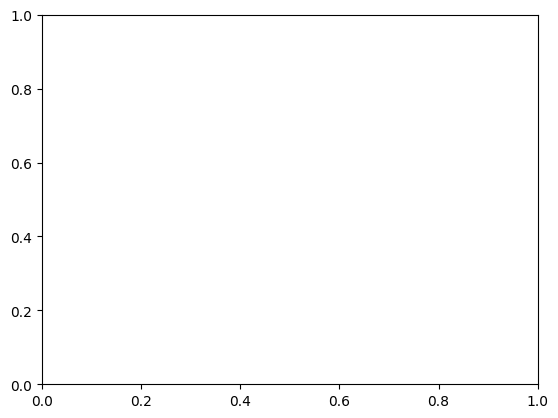

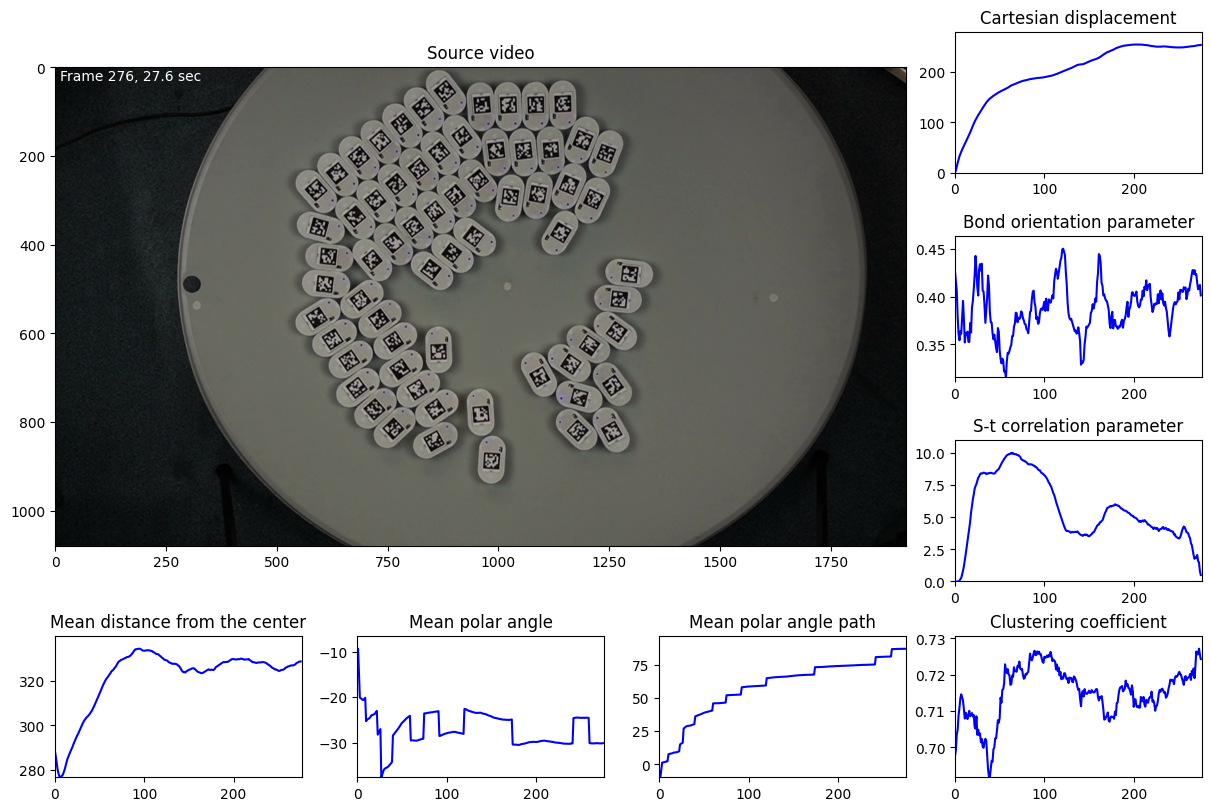

In [32]:
get_dashboard('another_test.gif',
                  cart_disp,
                  boo,
                  stcp, 
                  cl_coeff,
                  distance,
                  angle,
                  angle_abs,
                  10
                 )

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [00:09<00:00, 29.80it/s]


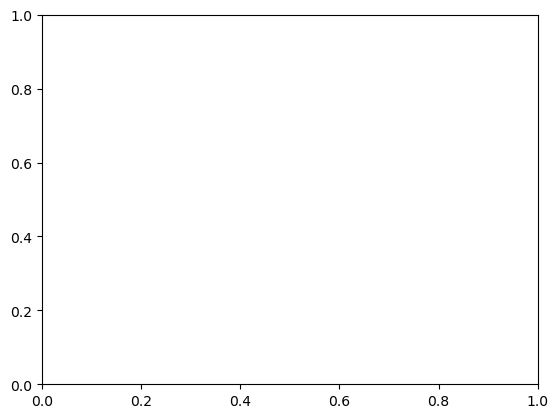

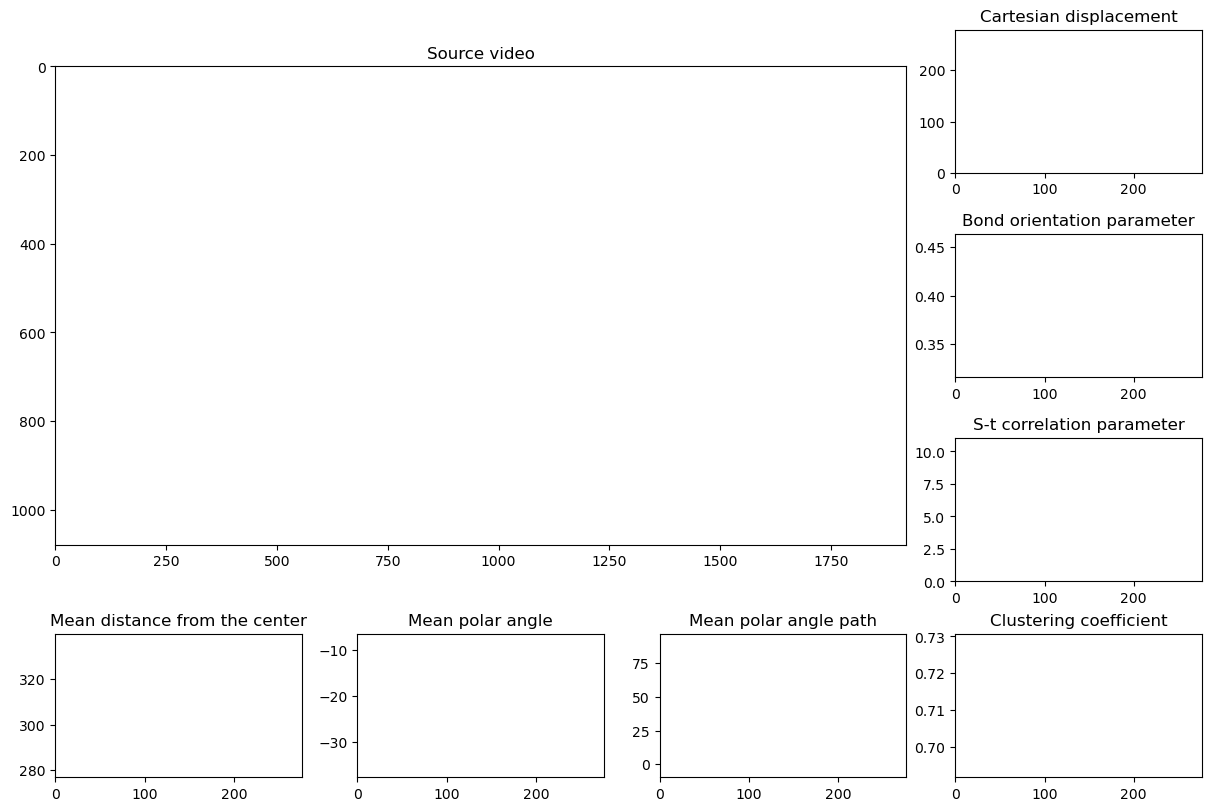

In [184]:
from matplotlib import pyplot as plt
from celluloid import Camera

fig, ax = plt.subplots()
fig = plt.figure(layout="constrained", figsize = (12,8))
gs = GridSpec(4, 4, figure=fig)
ax1 = fig.add_subplot(gs[:3, :3])
ax2 = fig.add_subplot(gs[:1, -1])
ax3 = fig.add_subplot(gs[1:2, -1])
ax4 = fig.add_subplot(gs[2:3, -1])
ax5 = fig.add_subplot(gs[3:4, -1])
ax6 = fig.add_subplot(gs[-1, 0])
ax7 = fig.add_subplot(gs[-1, 1])
ax8 = fig.add_subplot(gs[-1, 2])

camera = Camera(fig)

for i in tqdm(range(len(video))):
    
    ax1.imshow(video[i])
    ax1.text(x = 10, y = 30, s=f'Frame {i}, {round(i/10, 2)} sec', color ='white')

    ax1.set_title('Source video')

    ax2.set_title('Cartesian displacement')

    ax3.set_title('Bond orientation parameter')

    ax4.set_title('S-t correlation parameter')

    ax5.set_title('Clustering coefficient')

    ax6.set_title('Mean distance from the center')

    ax7.set_title('Mean polar angle')

    ax8.set_title('Mean polar angle path')
    
    axs = [ax2, ax3, ax4, ax5, ax6, ax7, ax8]
    data = [cart_disp, boo, stcp, cl_coeff, distance, angle, angle_abs]
    
    for d, ax in zip(data, axs):
        ax.plot(time[0:i], d[0:i])
        ax.axis(xmin = min(time), xmax = max(time), ymin = min(d), ymax = max(d) + 
             (max(d) - min(d))/10)
        
    camera.snap()
    

animation = camera.animate()
animation.save("test_video.gif")

# Video processing
<a name='processing' />

To extract the robots' trajectories from the video, we import the `Processor` class from `ampy.processing` and create the corresponding object:

In [14]:
from ampy.processing import Processor

VP = Processor()

Then we pass the videofile path using `set_filename` method:

In [15]:
VP.set_filename(filename)

From this moment we can extract system's **Cartesian kinematics** by the  `cartesian_kinamatics` function:

In [16]:
cart_kin = VP.cartesian_kinematics(bots_number=65,
                                    begin_frame=120,
                                    end_frame=1800,
                                    get_each=5,
                                    ignore_codes=(),
                                    scale_parameters=(1, 0))

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [01:20<00:00,  3.44it/s]
C:\Users\Eighonet Aerta\Desktop\AMPy\ampy\processing.py:366: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  total_ids = np.array(raw_kinematics[best_recognized_frame_number])[:, 0]
C:\Users\Eighonet Aerta\Desktop\AMPy\ampy\processing.py:372: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  current_ids = np.array(raw_kinematics[i_frame])[:, 0]
C:\Users\Eighonet Aerta\Desktop\AMPy\ampy\processing.py:380: VisibleDeprecationWarning: Creatin

We can see that this method holds 6 parameters: *bots_number* is a number of tracking objects presented in the video; *begin_frame* and *end_frame* describe a start/stop frames for kinematics extraction; *get_each* sets frames decimation frequency (to speed up the execution); *ignore_codes* is a list of markers' ids which are not considered during the tracking; *scale_parameters* correspond to the α and β parameters of a frame linear transformation (adjustable contrast and brightness parameters).

To extract the **polar representation of kinematics**, you should provide the coordinates of the field center. This can be done automatically using `field_center_auto` if you place additional markers on the area's borders. Otherwise, we can set it up manually:

In [7]:
center = (1920 // 2, 1080 // 2)

polar_kin = VP.polar_kinematics(cartesian_kinematics=cart_kin,
                                field_center=center)

100%|██████████████████████████████████████████████████████████████████████████████| 277/277 [00:00<00:00, 3846.88it/s]


In some cases, it can be beneficial to convert linear distances from pixels to centimeters. Scaling factor of such transformation can be obtained via `metric_constant` with respect to the size of ArUco markers:

In [8]:
marker_size = 3 # in centimeters

scaling_factor = VP.metric_constant(marker_size=marker_size, scale_parameters=(1, 0))

# Two-dimensional statistics
<a name='2dstats' />

Module `statistics2d` allows you to evaluate several characeristics represented in the form of temporal dependencies.

The one can obtain **mean displaiments of robots from the center** by the means of the `mean_distance_from_center` function:

In [9]:
from ampy.statistics2d import mean_distance_from_center

distance = mean_distance_from_center(kinematics=polar_kin)

**Mean polar angle of robots** in the system can be calculated via `mean_polar_angle`:

In [10]:
from ampy.statistics2d import mean_polar_angle

angle = mean_polar_angle(kinematics=polar_kin)

On top of that, you can evaluate mean polar angle **in sense of the angular path** using `mean_polar_angle_absolute`:

In [11]:
from ampy.statistics2d import mean_polar_angle_absolute

angle_abs = mean_polar_angle_absolute(kinematics=polar_kin)

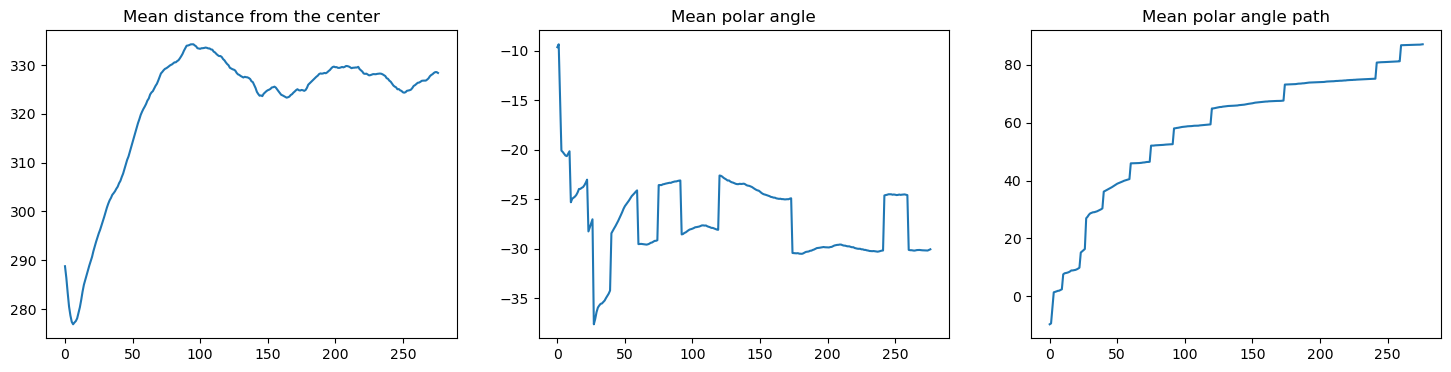

In [12]:
# now let us see how these characteristics look like

time = [i for i in range(len(cart_kin))]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

ax1.plot(time, distance)
ax1.set_title('Mean distance from the center')

ax2.plot(time, angle)
ax2.set_title('Mean polar angle')

ax3.plot(time, angle_abs)
ax3.set_title('Mean polar angle path')

plt.show()

**Mean squared distance** (to the center of the field) can be evaluated by the `mean_cartesian_displacements` function:

In [13]:
from ampy.statistics2d import mean_cartesian_displacements

cart_disp = mean_cartesian_displacements(kinematics=cart_kin)

In order to check whether system's configuration corresponds to some regular lattice, you can apply `bond_orientation` with the order parameter `neighbours_number`:

In [14]:
from ampy.statistics2d import bond_orientation

boo = bond_orientation(kinematics=cart_kin, neighbours_number=6, folds_number=6)

Spatio-temporal correlation of the system can be evaluated by the `chi_4` function:

In [15]:
from ampy.statistics2d import chi_4
from multiprocessing import Pool
import os

data = []
for time in time:
  data.append((cart_kin, time, 100))

with Pool(os.cpu_count()) as pool:
  stcp = pool.starmap(chi_4, data)

Clustering coefficient of the system can be obtained by the `cluster_dynamics` function:

In [16]:
from ampy.statistics2d import cluster_dynamics

cl_coeff = cluster_dynamics(kinematics=cart_kin)

This function has an optional parameter `collide_function` specifying collision rules for robots.

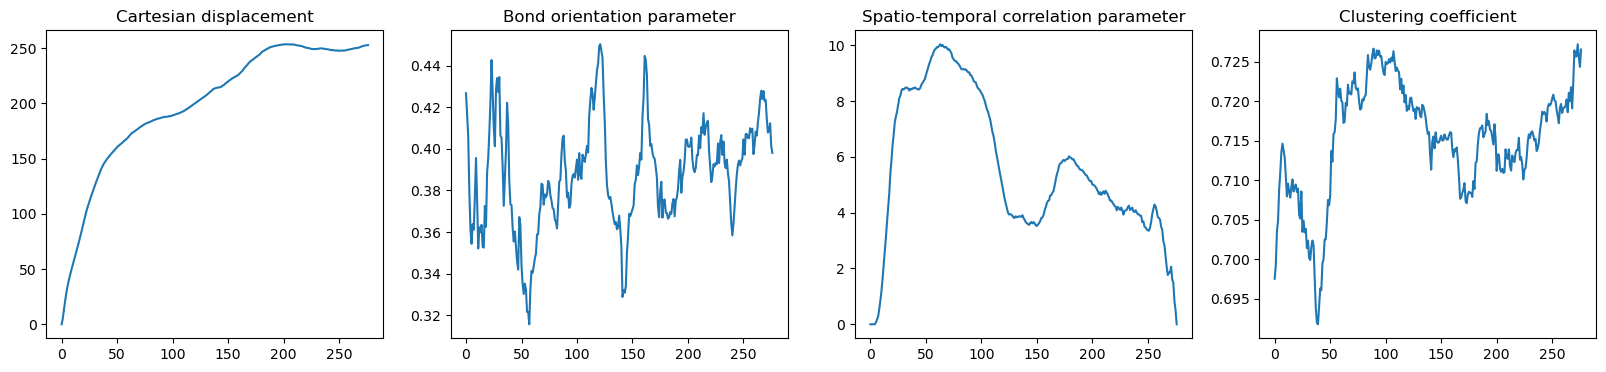

In [17]:
time = [i for i in range(len(cart_kin))]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))

ax1.plot(time, cart_disp)
ax1.set_title('Cartesian displacement')

ax2.plot(time, boo)
ax2.set_title('Bond orientation parameter')

ax3.plot(time, stcp)
ax3.set_title('Spatio-temporal correlation parameter')

ax4.plot(time, cl_coeff)
ax4.set_title('Clustering coefficient')

plt.show()

# Three-dimensional statistics
<a name='3dstats' />

**Correlations between robots positions**, **orientations** and **velocities** can be evaluated by the following functions: `position_correlation`, `orientation_corrilation`, and `velocity_correlation`. For simplicity, we will evaluate them in the 400x400 window:

In [18]:
from ampy.statistics3d import position_correlation, orientation_correlation, velocity_correlation

pos_corr = position_correlation(kinematics=cart_kin, x_size=200, y_size=200)

orient_corr = orientation_correlation(kinematics=cart_kin, x_size=200, y_size=200)

vel_corr = velocity_correlation(kinematics=cart_kin, x_size=200, y_size=200)

To provide better visul summary, you may average correlation maps for all processed frames:

In [19]:
import numpy as np

pos_corr = np.mean(np.array(pos_corr), axis=0)
orient_corr = np.mean(np.array(orient_corr), axis=0)
vel_corr = np.mean(np.array(vel_corr), axis=0)

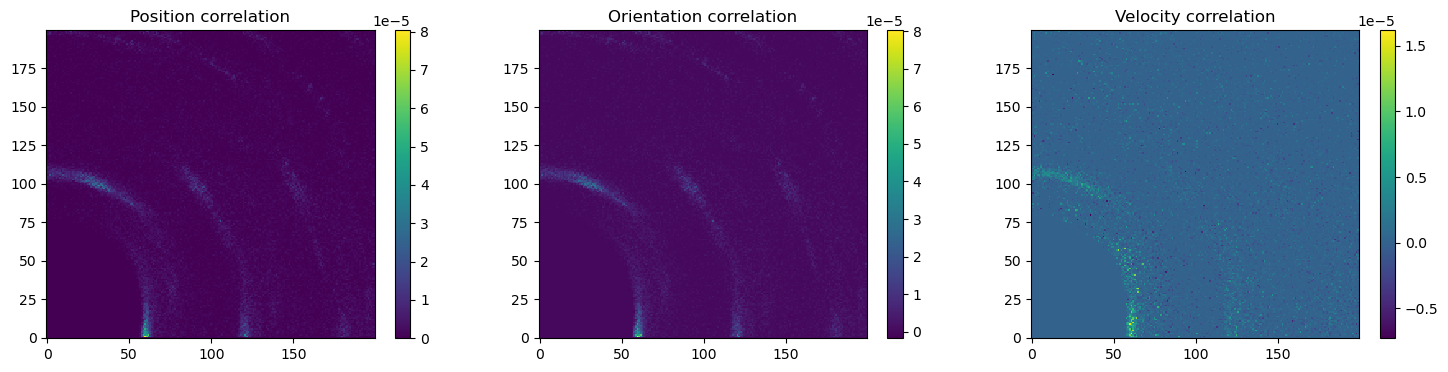

In [20]:
fig, (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(18, 4))

X, Y = np.linspace(0, 199, num=200), np.linspace(0, 199, num=200)

im_1 = ax_1.pcolor(X, Y, pos_corr)
ax_1.set_title('Position correlation')
fig.colorbar(im_1, ax=ax_1)

im_2 = ax_2.pcolor(X, Y, orient_corr)
ax_2.set_title('Orientation correlation')
fig.colorbar(im_2, ax=ax_2)

im_3 = ax_3.pcolor(X, Y, vel_corr)
ax_3.set_title('Velocity correlation')
fig.colorbar(im_3, ax=ax_3)

plt.show()

--------------------

If you have any questions about this tutorial, [you are welcome to open an issue](https://github.com/swarmtronics/AMPy/issues) in our GitHub repo.